## Model selection

### Topics

Out of scope: [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering); we assume we already have good enough features.

### DRY-violation warning

Note: the code below is to demonstrate the model selection pipeline of [risk_learning/model_selection/run-pipeline.py](..risk_learning/model_selection/run-pipeline.py), in violation of the DRY or [Do Not Repeat Yourself](https://en.wikipedia.org/wiki/Don't_repeat_yourself) principle.

See this repository's [commit history](https://github.com/munichpavel/risk-ai-workshop/commits/main), especially the [before](https://github.com/munichpavel/risk-ai-workshop/tree/ddbf4e07f25a51796bf5871bd595cefd8f870ba7/notebooks/model-selection-examples.ipynb) and [after](https://github.com/munichpavel/risk-ai-workshop/blob/2777d1ec4ab3fd9a3376fbdee3597dc2de1e38f1/notebooks/model-selection-examples.ipynb) commits of this notebook for examples of errors resulting from DRY violations.

In [1]:
import os
from pathlib import Path
import re

import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import xarray as xr

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import average_precision_score

from scipy.stats import pearsonr

import matplotlib.pyplot as plt

from fake_data_for_learning.contingency_tables import calculate_contingency_table

from risk_learning.simpson import (
    get_flat_combinations, 
    make_feature_combination_score_array,
    compute_margin
)

In [2]:
data_dir = Path(os.getcwd()) / 'data'
file_read_params = dict(delimiter=',')
target_col = 'default'
non_target_cols = ['gender', 'occupation', 'activity']
#non_target_cols = ['gender']
df = pd.read_csv(
    data_dir / 'default.csv', **file_read_params,
    usecols=non_target_cols + [target_col]
)
print(f'Shape of entire dataset: {df.shape}')
df.head()

Shape of entire dataset: (10000, 4)


,gender,occupation,activity,default
0,1,1,0,0
1,1,1,0,0
2,1,1,0,0
3,0,0,1,1
4,1,1,0,0


## Split data for model fitting

In [3]:
train_ratio = 0.4
test_ratio = 0.2

data_split_seed = 42
X = df[non_target_cols]
y = df[target_col]

# Split into train + validation  / test sets
X_train_validate, X_test, y_train_validate, y_test = train_test_split(
    X, y, test_size=test_ratio, random_state=data_split_seed
)

train_ratio_after_test_split = train_ratio / (1 - test_ratio)
X_train, X_validate, y_train, y_validate = train_test_split(
    X_train_validate, y_train_validate,
    train_size=train_ratio_after_test_split,
    random_state=data_split_seed
)

### A little Exploratory Data Analysis

Very little.

In [4]:
# Value ranges can be guessed from data or extracted from IT system
default_values = [0, 1]
gender_values = [0, 1]
occupation_values = [0, 1]
activity_values = [0, 1]
data_categories = dict(
    default=CategoricalDtype(categories=default_values, ordered=True),
    gender=CategoricalDtype(categories=gender_values, ordered=True),
    occupation=CategoricalDtype(categories=occupation_values, ordered=True),
    activity=CategoricalDtype(categories=activity_values, ordered=True)
)

# Recombine 
X_y_train = X_train.copy()
X_y_train['default'] = y_train.values
for column, c_type in data_categories.items():
    X_y_train[column] = X_y_train[column].astype(c_type)
    
contingency_table = calculate_contingency_table(X_y_train[data_categories.keys()])

#### Simpson's paradox example

In [5]:
female_default_rate = (
    compute_margin(contingency_table, dict(default=1, gender=0 )) 
    / compute_margin(contingency_table, dict(gender=0))
)
print('\nfemale empirical default rate', female_default_rate)
male_default_rate = (
    compute_margin(contingency_table, dict(default=1, gender=1)) 
    / compute_margin(contingency_table, dict(gender=1))
)
print('male empirical default rate', male_default_rate)


female empirical default rate 0.39509394572025053
male empirical default rate 0.30230326295585414


but in the occupation subpopulations ...

In [6]:
female_edu_default_rate = (
    compute_margin(contingency_table, dict(default=1, gender=0, occupation=0)) 
    / compute_margin(contingency_table, dict(gender=0, occupation=0))
)
print('\nfemale education default rate', female_edu_default_rate)
male_edu_default_rate = (
    compute_margin(contingency_table, dict(default=1, gender=1, occupation=0)) 
    / compute_margin(contingency_table, dict(gender=1, occupation=0))
)
print('male education default rate', male_edu_default_rate)
print('female education default higher', female_edu_default_rate > male_edu_default_rate)

female_health_default_rate = (
    compute_margin(contingency_table, dict(default=1, gender=0, occupation=1)) 
    / compute_margin(contingency_table, dict(gender=0, occupation=1))
)
print('\nfemale health default rate', female_health_default_rate)
male_health_default_rate = (
    compute_margin(contingency_table, dict(default=1, gender=1, occupation=1)) 
    / compute_margin(contingency_table, dict(gender=1, occupation=1))
)
print('male health default rate', male_health_default_rate)
print('female health default higher', female_health_default_rate > male_health_default_rate)


female education default rate 0.44920525224602625
male education default rate 0.46167883211678834
female education default higher False

female health default rate 0.2281449893390192
male health default rate 0.24544270833333334
female health default higher False


In [7]:
# Output default rates for use in slides
project_root = Path(os.getcwd()).parent
slides_dir = project_root / 'slides'
graphics_subdir_name = 'graphics'

practice_figure_dir = slides_dir / 'risk-and-ai-in-practice' / graphics_subdir_name

simpson_default_rates_df = pd.DataFrame(dict(
    population=['total', 'education', 'health'],
    female=[female_default_rate, female_edu_default_rate, female_health_default_rate],
    male=[male_default_rate, male_edu_default_rate, male_health_default_rate]
))

fn = practice_figure_dir / 'simpson-default-rates.tex'

table_tex = simpson_default_rates_df.to_latex(index=False)
with open(fn, 'w') as fp:
    fp.write(table_tex)

In [8]:
?correlations_df.style.to_latex

Object `correlations_df.style.to_latex` not found.


In [9]:
pairs = [('gender', 'default'), ('occupation', 'default'), ('activity', 'default')]
correlation_records = []
for pair in pairs:
    pearson_corr = pearsonr(X_y_train[pair[0]], X_y_train[pair[1]])
    print(f'Correlation of {pair}: {pearson_corr}')
    record = [str(pair), pearson_corr[0], pearson_corr[1]]
    correlation_records.append(record)
    
correlations_df = pd.DataFrame(correlation_records, columns=['pair', 'pearson_r', 'p_value'])
fn = practice_figure_dir / 'correlation-default-rates.tex'

# Escape column names
escaped_columns = [re.sub(r'([_\{}])', r'\\\1', col) for col in correlations_df.columns]
correlations_df.columns = escaped_columns

table_tex = correlations_df.reset_index(drop=True).style.to_latex()
with open(fn, 'w') as fp:
    fp.write(table_tex)

Correlation of ('gender', 'default'): PearsonRResult(statistic=-0.0973964313918792, pvalue=6.715668341047975e-10)
Correlation of ('occupation', 'default'): PearsonRResult(statistic=-0.22191503465529333, pvalue=8.141972326499778e-46)
Correlation of ('activity', 'default'): PearsonRResult(statistic=0.9532420824426235, pvalue=0.0)


In [10]:
# Other variables uses when evaluating different models
gender_values = [0, 1]
occupation_values = [0, 1]
activity_values = [0, 1]
feature_coords = dict(
    gender=gender_values,
    occupation=occupation_values,
    activity=activity_values
)
feature_combinations = get_flat_combinations(feature_coords)

## Fit models to training data and spot-check on validation data

In [11]:
first_n = 5
model_fitting_seed = 42
idxes_first_n = X_validate.index[:first_n]
X_validate_first_n = X_validate.loc[idxes_first_n, :]
y_validate_first_n = y_validate[:first_n]
sample_validate = X_validate_first_n.copy()
sample_validate['default'] = y_validate_first_n
sample_validate

,gender,occupation,activity,default
3188,0,0,1,0
8293,1,1,1,1
1710,0,1,0,0
7510,0,1,1,1
1461,1,1,1,1


## Logistic regression

In [12]:
hyperparams = {"C": 0.2, "random_state": model_fitting_seed}
clf = LogisticRegression(**hyperparams)
clf.fit(X_train, y_train)
clf.predict_proba(X_validate_first_n)

array([[0.06974375, 0.93025625],
       [0.10181445, 0.89818555],
       [0.98673556, 0.01326444],
       [0.08536568, 0.91463432],
       [0.10181445, 0.89818555]])

In [13]:
scores = clf.predict_proba(X_validate)
default_scores = scores[:, 1]
average_precision_score(y_validate, default_scores)

0.9512296208074651

In [14]:
# Default scores by gender
scores = clf.predict_proba(feature_combinations)[:, 1]
score_array = make_feature_combination_score_array(feature_combinations, scores)
mean_female_score = score_array.sel(gender=0).mean().values
mean_male_score = score_array.sel(gender=1).mean().values
print(clf.__class__, 'mean scores')
print(f'female: {mean_female_score}, male: {mean_male_score}')

<class 'sklearn.linear_model._logistic.LogisticRegression'> mean scores
female: 0.46865359597749223, male: 0.4598168032966625


## Decision tree

In [15]:
hyperparams = {
    "criterion": "gini", 
    "random_state": model_fitting_seed
}
clf = DecisionTreeClassifier(**hyperparams)
clf.fit(X_train, y_train)
clf.predict_proba(X_validate_first_n)

array([[0.0497076 , 0.9502924 ],
       [0.07371007, 0.92628993],
       [1.        , 0.        ],
       [0.04464286, 0.95535714],
       [0.07371007, 0.92628993]])

In [16]:
scores = clf.predict_proba(X_validate)
default_scores = scores[:, 1]
average_precision_score(y_validate, default_scores)

0.9484309761670509

In [17]:
# Default scores by gender
scores = clf.predict_proba(feature_combinations)[:, 1]
score_array = make_feature_combination_score_array(feature_combinations, scores)
mean_female_score = score_array.sel(gender=0).mean().values
mean_male_score = score_array.sel(gender=1).mean().values
print(clf.__class__, 'mean scores')
print(f'female: {mean_female_score}, male: {mean_male_score}')

<class 'sklearn.tree._classes.DecisionTreeClassifier'> mean scores
female: 0.4764123851294904, male: 0.4641092462783639


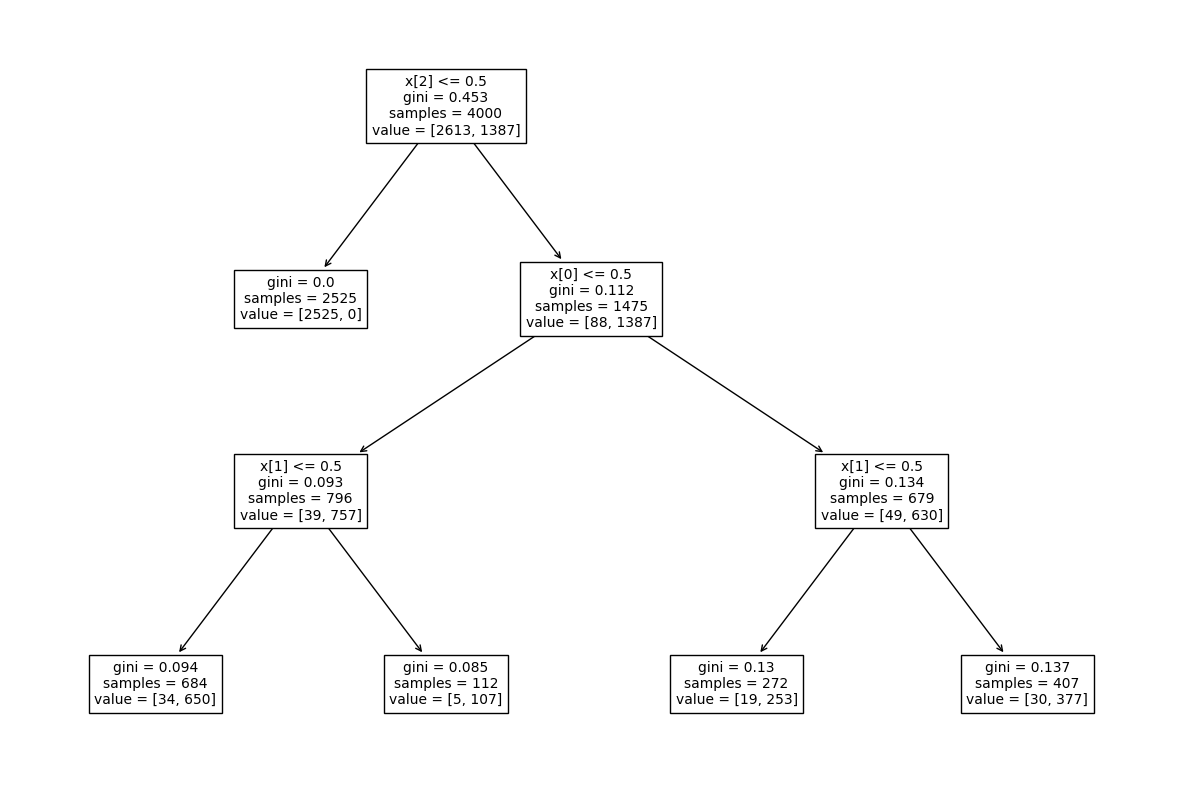

In [18]:
plt.figure(num=None,figsize=(15,10))
tree.plot_tree(clf, fontsize=10)
plt.show()

### Random Forest Classifier

In [19]:
hyperparams = {
    "n_estimators": 10, 
    "random_state": model_fitting_seed
}
clf = RandomForestClassifier(**hyperparams)
clf.fit(X_train, y_train)
clf.predict_proba(X_validate_first_n)

array([[0.05320282, 0.94679718],
       [0.07791748, 0.92208252],
       [1.        , 0.        ],
       [0.04080993, 0.95919007],
       [0.07791748, 0.92208252]])

In [20]:
scores = clf.predict_proba(X_validate)
default_scores = scores[:, 1]
average_precision_score(y_validate, default_scores)

0.9484309761670509

In [21]:
# Default scores by gender
scores = clf.predict_proba(feature_combinations)[:, 1]
score_array = make_feature_combination_score_array(feature_combinations, scores)
mean_female_score = score_array.sel(gender=0).mean().values
mean_male_score = score_array.sel(gender=1).mean().values
print(clf.__class__, 'mean scores')
print(f'female: {mean_female_score}, male: {mean_male_score}')

<class 'sklearn.ensemble._forest.RandomForestClassifier'> mean scores
female: 0.47649681166903024, male: 0.46408985878975895
